In [1]:
forward_primer = "GGDACWGGWTGAACWGTWTAYCCHCC"
reverse_primer = "TGRTTYTTYGGNCAYCCNGARGTNTA"
expected_distance = 313

input_base = "sampled_entries_2"
experiment_id = "_2"

input_fasta = input_base + ".fasta"
output_fasta = input_base + experiment_id + "_trimmed.fasta"
input_fastq = input_base + ".fastq"
output_fastq = input_base + experiment_id + "_trimmed.fastq"
input_csv = input_base + ".csv"
csv_output_path = input_base + experiment_id + "_results.csv"

json_report = input_base + experiment_id + "_fastp_report.json"
html_report = input_base + experiment_id + "_fastp_report.html"

n_repeats = 5  # how many times to run cutadapt

In [2]:
import subprocess
import time
import numpy as np

from primer_finder.matching.dtos.search_parameter_object import SearchParameterObject

# build cutadapt command
cmd = [
    "cutadapt",
    "--discard-untrimmed",
    "--rc",
    "-g", forward_primer + "..." + reverse_primer,
    "-o", output_fasta,
    "-e", "0.15",
    "-j", "8",
    input_fasta
]

# store runtimes
cutadapt_runtimes = []
for i in range(n_repeats):
    start = time.perf_counter()
    result = subprocess.run(cmd, capture_output=True, text=True)
    end = time.perf_counter()
    if result.returncode != 0:
        print(f"❌ fastp failed with return code {result.returncode}")
        print(result.stderr)

    elapsed = end - start
    cutadapt_runtimes.append(elapsed)
    print(f"Run {i+1}: {elapsed:.3f} seconds")

# convert to numpy for stats
cutadapt_runtimes = np.array(cutadapt_runtimes)

print("\nBenchmark results:")
print(f"  Mean: {cutadapt_runtimes.mean():.3f} seconds")
print(f"   Min: {cutadapt_runtimes.min():.3f} seconds")
print(f"   Max: {cutadapt_runtimes.max():.3f} seconds")
print(f"    SD: {cutadapt_runtimes.std():.3f} seconds")


Run 1: 16.261 seconds
Run 2: 16.667 seconds
Run 3: 14.998 seconds
Run 4: 13.186 seconds
Run 5: 14.216 seconds

Benchmark results:
  Mean: 15.066 seconds
   Min: 13.186 seconds
   Max: 16.667 seconds
    SD: 1.285 seconds


In [ ]:
from multiprocessing import Pool
from functools import partial
import pandas as pd
import primer_finder.matching.primer_finder as pf
from primer_finder.matching.dtos.match_result_dto import MatchResultDTO
from primer_finder.matching.dtos.search_parameter_object import SearchParameterObject
from tqdm import tqdm
import time

# since my implementation is not that well exposed apparently, I copied the relevant parts here that were not exposed properly yet.

df = pd.read_csv(input_csv)
query = SearchParameterObject(
    forward_primer=forward_primer,
    reverse_primer=reverse_primer,
    distance=expected_distance,
    forward_cutoff=0.7,
    reverse_cutoff=0.6,
    protein_translation_table=5,
)
null_counter = 0
primer_finder_runtimes = []
finder = pf.PrimerFinder(None)
seq_objs = []

for i, row in df.iterrows():
    if type(row["nuc_san"]) == str:
        seq_objs.append((row["specimen_id"], row["nuc_san"], MatchResultDTO(), MatchResultDTO()))
    else:
        null_counter += 1

for c in range(n_repeats):
    start = time.perf_counter()
    worker = partial(finder._process_sequences_chunk, query)

    sequence_chunks = pf.chunker(seq_objs, 1000)
    with Pool() as pool:
        results_buffer = []
        for wbv in pool.imap(worker, sequence_chunks, chunksize=1):
            results_buffer.extend(wbv)
    end = time.perf_counter()
    elapsed = end - start
    print(f"Run {c+1}: {elapsed:.3f} seconds")
    primer_finder_runtimes.append(elapsed)

primer_finder_runtimes = np.array(primer_finder_runtimes)

print("\nBenchmark results:")
print(f"  Mean: {primer_finder_runtimes.mean():.3f} seconds")
print(f"   Min: {primer_finder_runtimes.min():.3f} seconds")
print(f"   Max: {primer_finder_runtimes.max():.3f} seconds")
print(f"    SD: {primer_finder_runtimes.std():.3f} seconds")

# output mean min max and std mby?

In [104]:
import pandas as pd
from Bio import SeqIO

# Step 1: Extract IDs and amplicons from your results_buffer
my_ids = [entry[0] for entry in results_buffer]
my_amplicons = [entry[3] for entry in results_buffer]

# Step 2: Parse cutadapt output FASTA
cutadapt_dict = {}  # maps ID → trimmed sequence
for record in SeqIO.parse(output_fasta, "fasta"):
    cutadapt_dict[record.id] = str(record.seq)

# Step 3: Build the DataFrame
combined_data = []

for seq_id, my_amplicon in zip(my_ids, my_amplicons):
    cutadapt_amplicon = cutadapt_dict.get(str(seq_id), None)
    combined_data.append({
        "ID": seq_id,
        "MyProgram_Amplicon": my_amplicon,
        "Cutadapt_Amplicon": cutadapt_amplicon
    })

df_combined = pd.DataFrame(combined_data)

    ID                                 MyProgram_Amplicon  \
0  175  ACTTTCATCTAATATTGCCCATGGAGGTAGCTCTGTAGATTTAGCT...   
1  289  CCTTTCATCTAATATTGCCCATGGAGGAAGATCAGTAGACTTAGCC...   
2  577  TTTATCTTCTTATTTATTTCATTCATCTCCATCAATTGATATTGCA...   
3  688  ACTTTCATCTAATATTGCTCATAGAGGAAGATCAGTAGATTTAGCA...   
4  828  TCTTTCATCTAATATTGCCCATGGAGGAAGATCAGTAGATTTAGCT...   

                                   Cutadapt_Amplicon  
0                                               None  
1                                               None  
2                                               None  
3                                               None  
4  TCTTTCATCTAATATTGCCCATGGAGGAAGATCAGTAGATTTAGCT...  


In [105]:
df_combined["My_len"] = df_combined["MyProgram_Amplicon"].str.len()
df_combined["Cut_len"] = df_combined["Cutadapt_Amplicon"].str.len()


In [106]:
df_diff = df_combined[df_combined["MyProgram_Amplicon"] != df_combined["Cutadapt_Amplicon"]]
print(len(df_diff))

66424


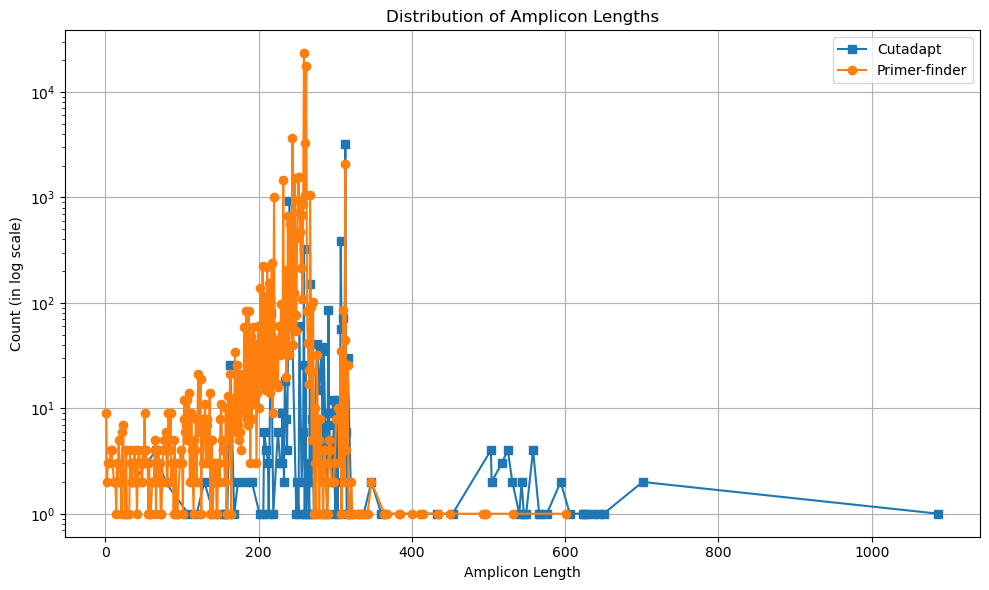

In [113]:
import matplotlib.pyplot as plt

# Count occurrences of each length
my_len_counts = df_combined['My_len'].value_counts().sort_index()
cutadapt_len_counts = df_combined['Cut_len'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(cutadapt_len_counts.index, cutadapt_len_counts.values, label='Cutadapt', marker='s')
plt.plot(my_len_counts.index, my_len_counts.values, label='Primer-finder', marker='o')

plt.xlabel('Amplicon Length')
plt.ylabel('Count (in log scale)')
plt.yscale('log')
plt.title('Distribution of Amplicon Lengths')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [108]:
df.to_csv(csv_output_path, index=False)